<a href="https://colab.research.google.com/github/team-signpin/signpin/blob/main/SignPin%5BRobin%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipycanvas

     |████████████████████████████████| 253 kB 4.9 MB/s 


In [ ]:
!pip install ipywidgets

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import json
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [ ]:
from ipywidgets import interact, interactive, HBox, VBox
import ipywidgets as widgets

In [ ]:
from ipycanvas import Canvas, hold_canvas


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
with open('./drive/MyDrive/data.json', 'r') as oldDataFile:
  oldData = json.loads(oldDataFile.read())

In [ ]:
canvas = Canvas(width=600, height=300)
canvas.layout.width = f'{canvas.width}px'
canvas.layout.height = f'{canvas.height}px'

In [ ]:
byNickname = {}

for signature in oldData['signatures']:
  nickname = signature['nickname']

  if nickname not in byNickname:
    byNickname[nickname] = []

  byNickname[nickname].append(signature['data'])

In [ ]:
def rotationMatrix(theta = np.pi / 2):
  cos, sin = np.cos(theta), np.sin(theta)

  return np.array(
    (
      (cos, -sin),
      (sin,  cos)
    )
  )

In [ ]:
def oldDataArray(nickname, index):
  basicArray = np.array([
          (row['x'], row['y'], row['ti'], row['ty'])
          for row in byNickname[nickname][index]
  ])

  tyCount = 0
  tys = basicArray[:, 3]
  lastTy = tys[0]

  for i in range(1, len(tys)):
    ty = tys[i]

    if lastTy != ty:
      tyCount += 1
      tys[i - 1] = tyCount

    tys[i] = tyCount
    lastTy = ty

  basicArray[:, 3] = tys

  rotate90 = rotationMatrix()
  R = rotate90

  basicArray[:, 0:2] = basicArray[:, 0:2] @ R

  xCoords = basicArray[:, 0]
  yCoords = basicArray[:, 1]

  # Calculate the gradient of straightline of best fit & take x-axis gradient.
  incline = np.polyfit(xCoords, yCoords, 1)[0]

  # Calculate Radians from gradient and take negative for straightening transform.
  inclineRadians = np.arctan(incline)*1

  straightenR = rotationMatrix(inclineRadians)
  basicArray[:, 0:2] = basicArray[:, 0:2] @ straightenR

  w, h = basicArray[:, 0:2].max(axis = 0) - basicArray[:, 0:2].min(axis = 0)
  ratio = w/h

  normalizeTillColumn = 4
  basicArray[:, 0:normalizeTillColumn] = basicArray[:, 0:normalizeTillColumn] - basicArray[:, 0:normalizeTillColumn].min(axis = 0)
  basicArray[:, 0:normalizeTillColumn] = basicArray[:, 0:normalizeTillColumn] / basicArray[:, 0:normalizeTillColumn].max(axis = 0)

  return (basicArray, ratio)

In [ ]:
def midTimeDebug(data, n):
  tis = data[:, 2]
  given_ti = n
  end_point = np.searchsorted(tis, given_ti)
  end_point_vti = data[end_point, 2]
  start_point_vti = data[end_point - 1, 2]
  start_d_point = data[end_point-1];
  end_d_point = data[end_point]
  div = (given_ti - start_point_vti) / (end_point_vti - start_point_vti)
  new_point_x = div * start_d_point[0] + (1-div) * end_d_point[0]
  new_point_y = div * start_d_point[1] + (1-div) * end_d_point[1]
  
  new_point = [new_point_x, new_point_y, given_ti, start_d_point[3]]
  new_point = [round(x, 5) for x in new_point]
  return new_point, (start_d_point, end_d_point)

In [ ]:
def normalizeByTime(data, n):
  return np.array([ midTime(data, (1/n) * x) for x in range(1,n)])


In [ ]:
def drawExtendedEdge(canvas, data, i):
  xi, yi, tii, peni = data[i]
  xj, yj, tij, penj = data[i + 1]
  magnitude = np.sqrt((xj - xi)**2 + (yj - yi) ** 2)
  slope = (yj - yi) / (xj - xi)
  c_val = yj - (slope * xj)
  direction = np.arctan((yj-yi)/(xj-xi))
  unit_vec = [xj - xi, yj - yi] / magnitude
  unit_vec = unit_vec * 0.08
  xj = xj + unit_vec[0]
  yj = slope * xj + c_val
  return xj, yj
  


tn = 100


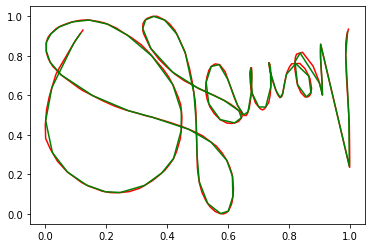

In [70]:
def midTime(data, n):
  tis = data[:, 2]
  given_ti = n
  end_point = np.searchsorted(tis, given_ti)
  end_point_vti = data[end_point, 2]
  start_point_vti = data[end_point - 1, 2]
  start_d_point = data[end_point-1];
  end_d_point = data[end_point]
  div = (given_ti - start_point_vti) / (end_point_vti - start_point_vti)

  # start = xu, end = xv, div = r
  # r*xu + (1-r)*xv
  # (xv - xu)*r + xu === xu*(1-r) + xv*r
  new_point_x = (end_d_point[0] - start_d_point[0])*div + start_d_point[0]
  new_point_y = (end_d_point[1] - start_d_point[1])*div + start_d_point[1]
  
  new_point = [new_point_x, new_point_y, given_ti, start_d_point[3]]
  new_point = [round(x, 5) for x in new_point]
  return new_point


data, ratio = oldDataArray('OMRAN', 0)
tmp, point2 = midTimeDebug(data, 0.75)
# p_data
# data
# data = data[10:]
tn = 100
p_data = normalizeByTime(data, tn)
plt.plot(data[:,0], data[:,1], 'r-')
plt.plot(p_data[:,0], p_data[:,1], 'g-')
print(f"tn = {tn}")
# t_data = np.array([ midTime(data, 0.01 * x) for x in range(1,100)])
# plt.plot(t_data[:,0], t_data[:,1], 'bo')

In [38]:
import math
def distance(p1, p2):
  return math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )

def cumulativeDistance(data):
  data = np.pad(data, ((0, 0), (0, 1)), mode='constant', constant_values=0)
  c_data = data
  sum = 0
  for i in range(0, len(data) -1):
    c_data[i][4] = sum
    next_point = [c_data[i+1][0], c_data[i+1][1]]
    current_point = [c_data[i][0], c_data[i][1]]
    sum += distance(current_point, next_point)
  return c_data

c_data = cumulativeDistance(data)
c_data

array([[0.12365285, 0.93001063, 0.        , 0.        , 0.        ],
       [0.09927301, 0.87798401, 0.02897259, 0.        , 0.0574556 ],
       [0.04553527, 0.73723121, 0.03565857, 0.        , 0.20811779],
       [0.03484636, 0.70572889, 0.0361043 , 0.        , 0.24138412],
       [0.02193709, 0.6405146 , 0.03989302, 0.        , 0.30786384],
       [0.01294461, 0.59235072, 0.04390461, 0.        , 0.35686001],
       [0.00424523, 0.52742815, 0.04747047, 0.        , 0.42236283],
       [0.        , 0.44883159, 0.05103633, 0.        , 0.50107395],
       [0.00117251, 0.38179661, 0.05482505, 0.        , 0.56811918],
       [0.01613363, 0.32969939, 0.05839091, 0.        , 0.62232209]])

total distance: 9.173689481580551
dn = 50


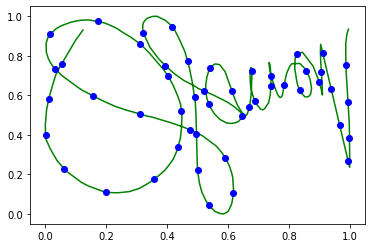

In [65]:
def normalizeByDistance(data, n):
  c_data = cumulativeDistance(data)
  total_distance = c_data[-2][4]
  print(f'total distance: {total_distance}')
  return np.array([ midDistance(c_data, (total_distance/n) * x) for x in range(1,n)])

def midDistance(data, n):
  dis = data[:, 4]
  given_di = n
  end_point = np.searchsorted(dis, given_di)
  end_point_vdi = data[end_point, 4]
  start_point_vdi = data[end_point - 1, 4]
  start_d_point = data[end_point-1];
  end_d_point = data[end_point]
  div = (given_di - start_point_vdi) / (end_point_vdi - start_point_vdi)

  new_point_x = (end_d_point[0] - start_d_point[0])*div + start_d_point[0]
  new_point_y = (end_d_point[1] - start_d_point[1])*div + start_d_point[1]
  
  new_point = [new_point_x, new_point_y, start_d_point[2], start_d_point[3], given_di]
  new_point = [round(x, 5) for x in new_point]
  return new_point


data, ratio = oldDataArray('OMRAN', 0)
# c_data = cumulativeDistance(data)
# n_point, start, end = midDistance(c_data, 1.95)
dn = 50
n_point = normalizeByDistance(data, dn)
plt.plot(data[:,0], data[:,1], 'g-')
plt.plot(n_point[:, 0], n_point[:, 1], 'bo')
# plt.plot(start[0], start[1], 'rx')
# plt.plot(end[0], end[1], 'rx')
print(f"dn = {dn}")

In [ ]:
nicknameSelector = widgets.Dropdown(
    options=tuple(byNickname.keys()),
    description='Nicknames: ',
)

signatureSelector = widgets.Dropdown(
    options=tuple(range(0, len(byNickname[nicknameSelector.value]))),
    description='Sign: ',
)

speedSelector = widgets.FloatSlider(
    value=1,
    min=0.3,
    max=10.0,
    description='Speed (s): ',
)

animateButton = widgets.Button(
    description='Animate'
)

def render(animate = False):
  canvas.clear()

  nickname = nicknameSelector.value
  index = int(signatureSelector.value)

  data, ratio = oldDataArray(nickname, index)
  data = data[7:14]
  # calculate gradient

  # data = normalizedByTime(data);

  if ratio > (canvas.width / canvas.height):
    width = canvas.width
    height = canvas.width / ratio
    yOffset = (canvas.height - height) / 2
    xOffset = 0

  else:
    height = canvas.height
    width = height * ratio
    yOffset = 0
    xOffset = (canvas.width - width) / 2


  with hold_canvas(canvas):
    for i in range(len(data) - 1):
      xi, yi, tii, peni = data[i]
      xj, yj, tij, penj = data[i + 1]
      magnitude = np.sqrt((xj - xi)**2 + (yj - yi) ** 2)
      slope = (yj - yi) / (xj - xi)
      c_val = yj - (slope * xj)
      direction = np.arctan((yj-yi)/(xj-xi))
      unit_vec = [xj - xi, yj - yi] / magnitude
      canvas.stroke_style = f'hsl({tii * 27000}, 100%, 50%)';
      canvas.font = '15px serif'
      # print(f'{i} - ti={tii}, m=({slope}) delT={tij-tii}')
      # print(f'{unit_vec}')
      # canvas.stroke_text(f'm=({slope}) delT={tij-tii} dir={np.degrees(direction)}', 10, 32 + 32 * i)
      canvas.begin_path()
      canvas.stroke_style = f'hsl({tii * 5100}, 100%, 50%)';

      canvas.move_to(
          xOffset + xi * width,
          yOffset + yi * height
      )

      
      # canvas.move_to(
      #     xOffset + 10 + xi * width,
      #     yOffset + 10 + yi * height
      # )

      # canvas.line_to(
      #     xOffset + 10 + xj * width,
      #     yOffset + 10 + yj * height
      # )

      extended_x, extended_y = drawExtendedEdge(canvas, data, i);
      canvas.line_to(
          xOffset + extended_x * width,
          yOffset + extended_y * height
      )
      
      canvas.stroke()
      canvas.close_path()

      if animate:
        canvas.sleep(
            float(speedSelector.value) * 1000 * (tij - tii)
        )


def chooseNickname(nickname):
  signatureSelector.options = tuple(range(0, len(byNickname[nickname])))
  signatureSelector.value = 0

def chooseSignature(index):
  render()

def animate(_):
  render(True)


nicknameSelectorInteractive = interactive(chooseNickname, nickname = nicknameSelector)
signatureSelectorInteractive = interactive(chooseSignature, index = signatureSelector)
animateButton.on_click(animate)

VBox([
      HBox([nicknameSelectorInteractive, signatureSelectorInteractive, speedSelector, animateButton]),
      canvas
])